# Standard imports

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

In [56]:
df_mc=pd.read_hdf('/eos/user/j/jglatzer/L2Output_R20_Nov_v2/pandas_ge6jge4b.h5', 'INC_ge6jge4b')

# Prepare data for parameterised H+ classification

split into test and training data

In [57]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass="multi",addMass=True)
print X_train.columns, X_train.shape

Index([u'nJets', u'nBTags_70', u'pT_jet1', u'Mbb_MindR_70', u'pT_jet5',
       u'H1_all', u'dRbb_avg_70', u'dRlepbb_MindR_70', u'Muu_MindR_70',
       u'HT_jets', u'Mbb_MaxPt_70', u'Mbb_MaxM_70', u'Mjjj_MaxPt',
       u'Centrality_all', u'hpmass'],
      dtype='object') (240845, 15)


In [58]:
HpMLUtils.summarizeFitData(X_train, y_train,w_train, categories=X_train.hpmass, showavevar=False)

X.shape= (240845, 15) y.shape= (240845,) w.shape= (240845,)
columns= Index([u'nJets', u'nBTags_70', u'pT_jet1', u'Mbb_MindR_70', u'pT_jet5',
       u'H1_all', u'dRbb_avg_70', u'dRlepbb_MindR_70', u'Muu_MindR_70',
       u'HT_jets', u'Mbb_MaxPt_70', u'Mbb_MaxM_70', u'Mjjj_MaxPt',
       u'Centrality_all', u'hpmass'],
      dtype='object')
categories= [-1, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]

sum of weights per category
       all 2629.88364197
        -1 1773.19189844
       200 103.250553623
       225 139.411907258
       250 140.771630765
       275 127.898508052
       300 113.685310171
       350 84.2383198254
       400 64.2254739452
       500 35.5521471196
       600 20.4739117537
       700 11.9823418924
       800 6.98221093499
       900 4.23840639368
      1000 2.47180734161
      1200 0.923953878111
      1400 0.3590526612
      1600 0.140958591035
      1800 0.0596178342679
      2000 0.0256314961018




ok the columns include the H+ mass now

Now on to scaling the weights to have a flat distributiong in H+ mass

In [59]:
sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)
sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)
w_train.groupby(X_train.hpmass).sum()

hpmass
-1       0.500000
 200     0.006538
 225     0.006538
 250     0.006538
 275     0.006538
 300     0.009676
 350     0.013075
 400     0.019613
 500     0.026151
 600     0.026151
 700     0.026151
 800     0.026151
 900     0.026151
 1000    0.039226
 1200    0.052301
 1400    0.052301
 1600    0.052301
 1800    0.052301
 2000    0.052301
Name: weight, dtype: float64

now set the hpmass for the background correctly (same PDF as signal)

In [60]:
from scipy.stats import rv_discrete

signalsum=w_train[X_train.hpmass>0].sum()
xk=[]
pk=[]
for name, group in w_train.groupby(X_train.hpmass):
    if name>0:
        xk.append((-1)*name)
        pk.append(group.sum()/signalsum)
#print xk,pk
custm=rv_discrete(values=(xk,pk))
#print "before resetting hpmass", sorted(X_train.hpmass.unique())
X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
#print "resetting hpmass", sorted(X_train.hpmass.unique())

print "the following is the difference between + and - mass"
print (w_train*((X_train.hpmass>0)-0.5)*2).groupby(X_train.hpmass.abs()).sum()
print "the following is the sum of weights"
print w_train.groupby(X_train.hpmass).sum()

X_train.hpmass=X_train.hpmass.abs()

the following is the difference between + and - mass
hpmass
200     0.001173
225     0.000484
250     0.000614
275     0.001261
300    -0.001718
350     0.000007
400    -0.000024
500     0.000749
600     0.000844
700    -0.001569
800     0.000928
900    -0.000477
1000    0.000598
1200    0.000101
1400   -0.002255
1600   -0.001980
1800   -0.000600
2000    0.001864
dtype: float64
the following is the sum of weights
hpmass
-2000    0.050437
-1800    0.052901
-1600    0.054281
-1400    0.054556
-1200    0.052200
-1000    0.038627
-900     0.026628
-800     0.025222
-700     0.027720
-600     0.025307
-500     0.025402
-400     0.019637
-350     0.013068
-300     0.011394
-275     0.005277
-250     0.005924
-225     0.006053
-200     0.005364
 200     0.006538
 225     0.006538
 250     0.006538
 275     0.006538
 300     0.009676
 350     0.013075
 400     0.019613
 500     0.026151
 600     0.026151
 700     0.026151
 800     0.026151
 900     0.026151
 1000    0.039226
 1200    0.052301


## Training the classifier

In [134]:
clf=HpAlgorithms.getGradientBDTClassifier(options = {'n_estimators': 200, 'learning_rate': 0.1}) #let's get away from the default trees to get a better performance

let's have a quick look if those parameters are roughly ok for mH+=800 GeV

Training for  200
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDTval_n_estimators_criterionfriedman_mse_initNone_learning_rate01_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators200_presortauto_random_state0_subsample10_verbose0_warm_startFalse.png


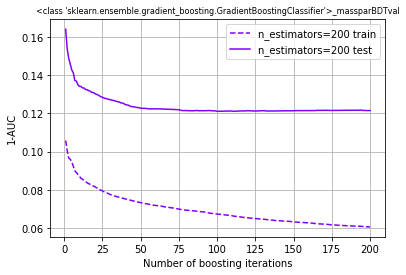

In [140]:
reload(HpHyperParameterOptimisation)
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)
opt=HpHyperParameterOptimisation.HpOptimise("massparBDTval",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
opt.saveValidationCurve(variable="n_estimators")

Training for  120
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDTval_n_estimators_criterionfriedman_mse_initNone_learning_rate013_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_presortauto_random_state0_subsample10_verbose0_warm_startFalse.png


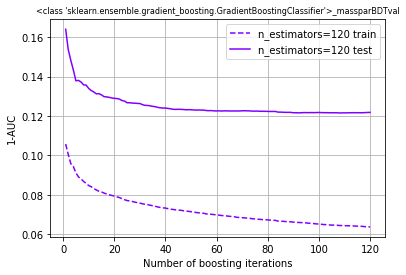

In [141]:
clf=HpAlgorithms.getGradientBDTClassifier(options = {'n_estimators': 120, 'learning_rate': 0.13}) #let's get away from the default trees to get a better performance
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)
opt=HpHyperParameterOptimisation.HpOptimise("massparBDTval",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
opt.saveValidationCurve(variable="n_estimators")

In [62]:
%time clf.fit(X_train, y_train, sample_weight=w_train)

CPU times: user 2min 6s, sys: 95.8 ms, total: 2min 7s
Wall time: 2min 6s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=200,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

This is pretty fast now....

## Evaluating the classifier for all H+ masses

In [73]:
def prepareTestDS(hpmass,X_test,y_test,w_test):
    mask=(X_test.hpmass==hpmass) | (X_test.hpmass<=0)
    X_new=X_test.copy()
    X_new["hpmass"]=hpmass
    return X_new[mask], y_test[mask], w_test[mask]
print sorted(X_test.hpmass.unique())

[-1, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]


In [74]:
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

print "1-ROC AUC for different masses in 6j4b - test, train"

trainvalues=[]
testvalues=[]
X_testfilter={}
y_testfilter={}
w_testfilter={}
X_trainfilter={}
y_trainfilter={}
w_trainfilter={}

for hpmass in hpmasses:
    X_trainfilter[hpmass], X_testfilter[hpmass], _, y_trainfilter[hpmass], y_testfilter[hpmass],_, w_trainfilter[hpmass], w_testfilter[hpmass], _=htf.prepare(hpmass=hpmass,addMass=True)
    X_trainfilter[hpmass].hpmass=hpmass
    X_testfilter[hpmass].hpmass=hpmass
  
    opt=HpHyperParameterOptimisation.HpOptimise("massparBDT"+str(hpmass),clf,X_trainfilter[hpmass],y_trainfilter[hpmass],w_trainfilter[hpmass],X_testfilter[hpmass],y_testfilter[hpmass],w_testfilter[hpmass])
    test,train=opt.test(X_trainfilter[hpmass], y_trainfilter[hpmass], w_trainfilter[hpmass], X_testfilter[hpmass], y_testfilter[hpmass], w_testfilter[hpmass])
    trainvalues.append(train)
    testvalues.append(test)

    print hpmass, test, train

1-ROC AUC for different masses in 6j4b - test, train
200 0.41847791371607745 0.3814693382898683
225 0.39570198914948773 0.36286661573662937
250 0.392498154625303 0.348908284017606
275 0.36718409432152976 0.3320797150205419
300 0.3475570505532869 0.3136325157874592
350 0.3281867947241648 0.29482566014032396
400 0.305077344458044 0.2674852373002915
500 0.2386065274611755 0.21604951871422817
600 0.19317330503267782 0.17162158952146778
700 0.15197368761716945 0.13085532928704147
800 0.12149857108670647 0.10252633656228638
900 0.09538186111417846 0.08355890017284562
1000 0.08020536355391772 0.06560912774952976
1200 0.0512562730824645 0.04022771251881041
1400 0.036833643935292315 0.027972975371433284
1600 0.026638594405145155 0.020090693597972886
1800 0.020312027759466833 0.01402659640299131
2000 0.015011972250102867 0.011087323105671731


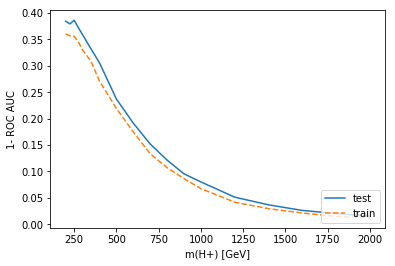

In [31]:
plt.plot(hpmasses, testvalues, '-', label='test')
plt.plot(hpmasses, trainvalues, '--', label='train')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")

There is basically no overtraining --> we can probably win a bit of sensitivity by moving towards a higher number of trees and more depth or lower learning rate

## Optimising the hyperparameters for m(H+)=800 GeV
and hoping it holds independently

In [32]:
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)

Validation curve for learning_rate
Training for  0.05
Training for  0.1
Training for  0.13
Training for  0.2
Training for  0.5
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDT800_learning_rate_criterionfriedman_mse_initNone_learning_rate05_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_presortauto_random_state0_subsample10_verbose0_warm_startFalse.png
Validation curve for max_depth
Training for  3
Training for  4
Training for  5
Training for  6
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDT800_max_depth_criterionfriedman_mse_initNone_learning_rate05_lossdeviance_max_depth6_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_presortauto_random_state0_subsample10_verbose0_warm_startFalse.png


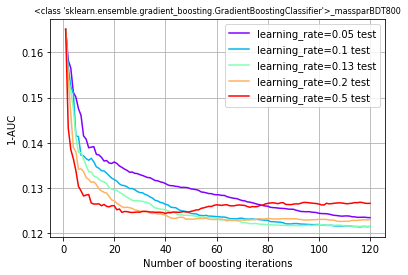

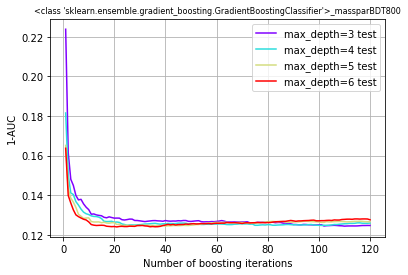

In [33]:
hpopt=HpHyperParameterOptimisation.HpOptimise("massparBDT800",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
hpopt.saveAllValidationCurves()

## Training the classifier at N-1 masses and checking at the remaining mass

In [39]:
from scipy.stats import rv_discrete
sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)

trainvalues_cross=[]
testvalues_cross=[]
for hpmass in hpmasses:
    X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass, addMass=True, invertsignal=True)
    sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
    X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)

    signalsum=w_train[X_train.hpmass>0].sum()
    xk=[]
    pk=[]
    for name, group in w_train.groupby(X_train.hpmass):
        if name>0:
            xk.append((-1)*name)
            pk.append(group.sum()/signalsum)
    
    custm=rv_discrete(values=(xk,pk))
    X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
    X_train.hpmass=X_train.hpmass.abs()
    
    clf=HpAlgorithms.getGradientBDTClassifier()
    clf.fit(X_train, y_train, sample_weight=w_train)
    X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval =htf.prepare(hpmass=hpmass, addMass=True, invertsignal=False)
    
    #X_testfilter[hpmass],y_testfilter[hpmass],w_testfilter[hpmass]=prepareTestDS(hpmass,X_test,y_test,w_test)
    X_test["hpmass"]=hpmass
    X_train["hpmass"]=hpmass
    opt=HpHyperParameterOptimisation.HpOptimise("massparBDT"+str(hpmass),clf,X_train,y_train,w_train,X_test,y_test,w_test)
    test,train=opt.test(X_train, y_train, w_train, X_test, y_test, w_test)
    trainvalues_cross.append(train)
    testvalues_cross.append(test)
    print hpmass, test, train

200 0.44579828374059804 0.4232946452504115
225 0.3863396732493215 0.3613781911636391
250 0.38692585043022687 0.35968566511992894
275 0.380077006184236 0.3524233395977394
300 0.3623541596264287 0.3329250930311287
350 0.3458481957252578 0.31932552646644063
400 0.3090555585635594 0.27867107268340885
500 0.2588386519668454 0.24851974124231657
600 0.20172709890933793 0.18538657835053451
700 0.15623437400989837 0.14049029564442883
800 0.12295083833275056 0.10846065740183541
900 0.09624045512146451 0.08802195046428984
1000 0.08092007115416522 0.07009230207010708
1200 0.05340148726299776 0.04385664011747392
1400 0.037804781204080595 0.029765608525607612
1600 0.0278009679154122 0.021960646770429637
1800 0.021832121825968276 0.015059129704743324
2000 0.016514898385069032 0.01255354419023269


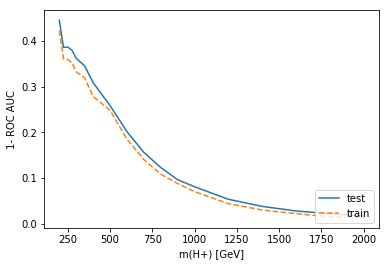

In [40]:
plt.plot(hpmasses, testvalues_cross, '-', label='test')
plt.plot(hpmasses, trainvalues_cross, '--', label='train')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

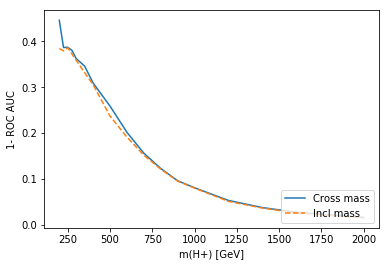

In [41]:
plt.plot(hpmasses, testvalues_cross, '-', label='Cross mass')
plt.plot(hpmasses, testvalues, '--', label='Incl mass')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

--> It seems that leaving out one mass point in between almost makes no difference (exception: 200 GeV, but that's not really a surprise)

### let's see how this converts to the default BDT

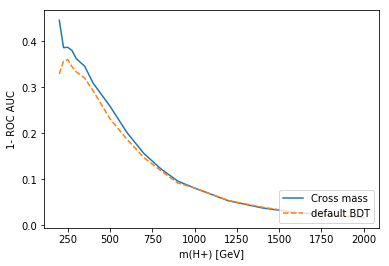

In [43]:
testdefaultBDT=[0.3290841140322679, 0.3566890794845421, 0.3602662115193581, 0.34498428916467183, 0.33375748714257425, 0.32019286312547357, 0.29225728165594855, 0.23146437865390979, 0.18697956512088676, 0.14718158177504637, 0.11895855659790655, 0.09204235231427149, 0.08130798049109356, 0.05375180442290828, 0.039379786382951254, 0.028362194212484093, 0.022254177247589824, 0.0160571366514084]
plt.plot(hpmasses, testvalues_cross, '-', label='Cross mass')
plt.plot(hpmasses, testdefaultBDT, '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

and how about cross section limit

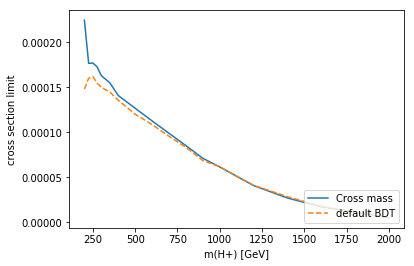

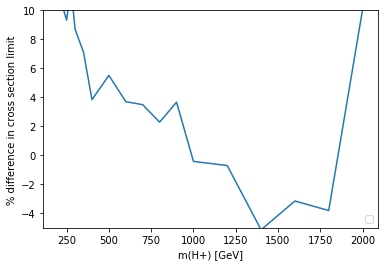

In [51]:
z=[ 5.84983620e-03, -4.16702246e-03,  1.22938606e-03, -1.36789294e-05] #fit values for ROC AUC to cross section limit comparison
f=np.poly1d(z)
plt.plot(hpmasses, f(testvalues_cross), '-', label='Cross mass')
plt.plot(hpmasses, f(testdefaultBDT), '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('cross section limit')
plt.legend(loc="lower right")
plt.show()

#and not %difference
plt.plot(hpmasses, (f(testvalues_cross)/f(testdefaultBDT)-1)*100, '-')
#plt.plot(hpmasses, f(testdefaultBDT), '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('% difference in cross section limit')
plt.legend(loc="lower right")
plt.ylim((-5,10))
plt.show()


one problem with the BDT is probably that the BDT score per event is not exactly smooth (probably quite ok as the distribution should be pretty smooth)

In [128]:
def decisionfunction(eventnumber):
    testmasses=np.linspace(200,2000, 1801)
    line1=X_test.iloc[eventnumber].copy()
    df = pd.DataFrame([line1]*len(testmasses))
    df["hpmass"]=testmasses
    y_pred=clf.decision_function(df)
    y_pred[:5]
    plt.plot(testmasses, y_pred, '-')
    plt.xlabel('m(H+) [GeV]')
    plt.ylabel('BDT score')
    #plt.legend(loc="lower right")
    plt.show()

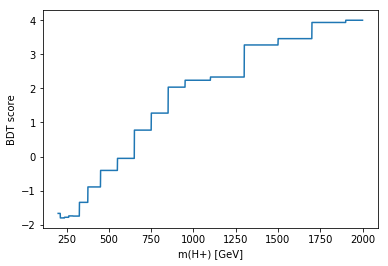

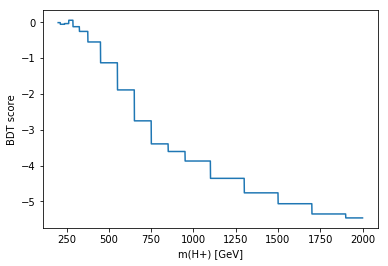

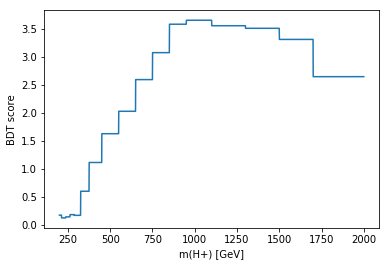

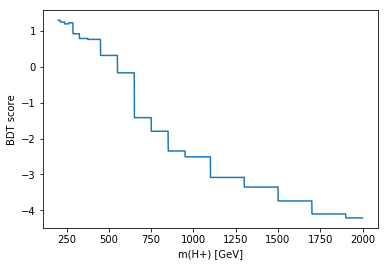

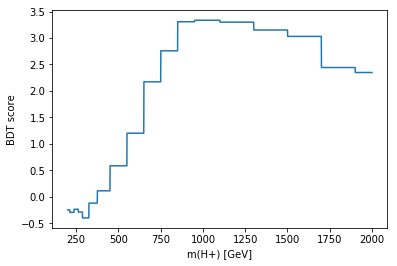

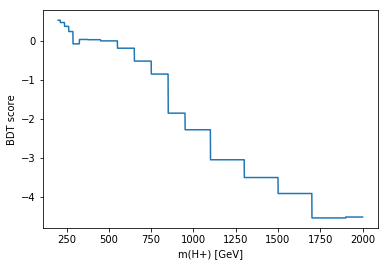

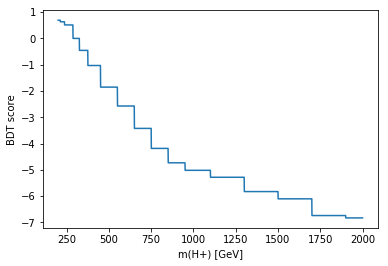

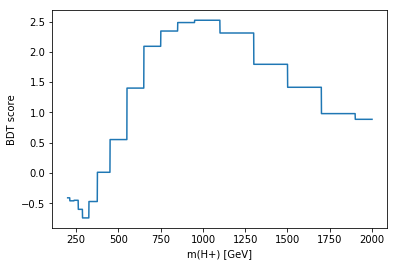

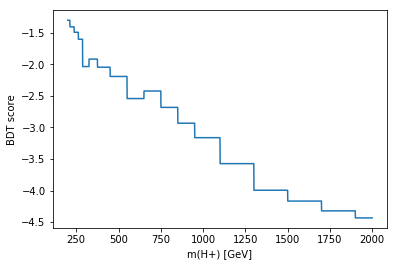

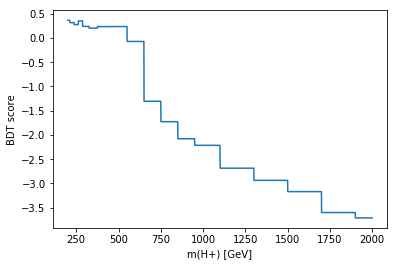

In [130]:
for i in range(0,10):
    decisionfunction(i)
